### TensorFlow Hub
In this unit, we will see how to download state of the art pretrained neural networks from TensorFlow Hub and use them to extract high-level features from complex, structured inputs that we can then use with the machine learning models from the course such as logistic regression, random forests etc.



When using a pretrained model for feature extraction, the model acts as a transformer. It converts the original features (pixels in an image, words in a text, sound waves in an audio recording, etc.) into a new set of features that is hopefully easier to use for machine learning. These new features will typically make little sense to us. But they are extracted from models that have been extensively trained on huge datasets. These new features encode various properties and aspects of our data far better than we could achieve by starting from scratch.

You can directly import TensorFlow Hub from the adsml course environment



In [1]:
import tensorflow as tf
import tensorflow_hub as hub

All models are available via the hub library. For reference, here are a few important links

* https://www.tensorflow.org/hub/
* https://tfhub.dev/

The models are classified by type of input and task. In this unit, we will use MobileNet v2 to extract a feature vector from an image and the Universal Sentence Encoder model to extract embeddings from texts i.e. texts high-level representations that we can use in our machine learning tasks.

#### Image feature extraction
Let’s start by loading the image from the previous unit. The image can be downloaded from this unit’s resources.

In [2]:
%matplotlib inline
from IPython.display import display
import PIL.Image as Image
import numpy as np

# Load image
img = Image.open("c4_photo.jpg")

# Create batch for network
img_resized = img.resize([224, 224], resample=Image.BILINEAR)  # Expected size
img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :] / 255
print("Batch size:", img_batch.shape)


Batch size: (1, 224, 224, 3)


We have named the array containing our single image img_batch. This is done on purpose so that you can see in the code where we could use batches of images, e.g. those created by an ImageDataGenerator using flow_from_directory as described in the previous unit “Advanced Keras”.

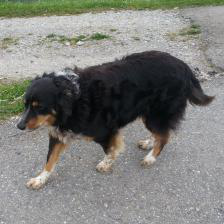

In [3]:
display(img)

By default, TensorFlow Hub image models work with float32 images normalized between zero and one. The expected input size is written on the MobileNet V2 model page. In this case, it’s 224x224.

Observe that we resize the image to the required input size of the model and then rescale its pixel values to match the input requirements of the pretrained model. However, we don’t use any augmentation techniques (rotate, flip, etc.) as we are not re-training the model. Instead, the pretrained model acts as a transformer. This also means that we don’t need to worry about batch_size.

In [6]:
# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Two options:
# 1
feature_extractor = hub.load(model_url)
# 2
# feature_extractor = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)

To load the pretrained MobileNet V2 network, we just need to pass the appropriate URL. We have two ways to do that as shown in the code above: using hub.load() to load the network as a TensorFlow model, or using hub.KerasLayer() to load it as a Keras model.

Let’s use our pretrained feature_extractor to extract the features for each image in img_batch

In [7]:
# Extract features
features = feature_extractor(img_batch)
features.shape


TensorShape([1, 1280])

We get one row for each image in img_batch. The size of the feature vector generated by each image can be found in the MobileNet V2 model page. In this case, it is a vector with 1,280 values that we can now use as a high-level representation in our machine learning tasks ex. image classification, clustering, etc.

Let’s take a look at the distribution of the feature

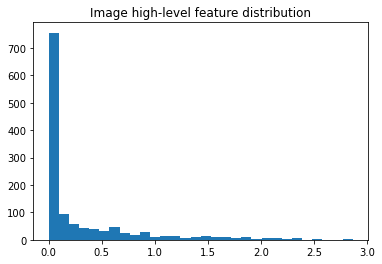

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(features[0].numpy(), bins=30)
plt.title("Image high-level feature distribution")
plt.show()


We can see that our network returned positive values and that most of the features are very small. Note that we used the numpy() method to convert the features before plotting.

#### Text embeddings
We just saw above how to extract a set of high-level features from an image. This is really convenient as images are complex inputs: they have a “spatial structure” i.e. pixels are arranged on a 2d grid. This structure is important to understand the content of the image: would you be able to recognize the dog on the image from above if the image pixels were randomly shuffled? For this reason, the “classical models” that we have seen at the beginning of this course would be a bad fit for this kind of input, because they do not take into account any spatial structure: shuffling the columns of the X matrix before a random forest, k-NN, or logistic regression doesn’t change the results!

Images are not the only input with a structure, audio and texts are two common examples where the input displays some temporal structure, e.g. the order of the words in a sentence is important. In other words, when working with such input, we need to find a way to extract a set of “high-level features” that we can then pass to the classical ML models. This can be done by manually defining what those features should be. For instance, in a text classifier that identifies paragraphs related to energy and politics, we could create a set of indicator variables for popular words related to those two topics: e.g. power, atom, solar, polls, election, senate. The other approach seen above with images is to “re-use” a neural network that was specifically trained on a large amount of data using lot of computational resources to extract meaningful high-level features.

TensorFlow Hub provides many different models to achieve this for four “structured” data types: image, text, video, and audio. The code is generally similar to the one shown above, with only the model_url changing and potentially some preprocessing depending on the model. In the case of texts, extracting high-level features is often referred to as “computing embeddings” - you can check this page to have a full list of TensorFlow models to compute text embeddings: TensorFlow text embeddings models.

For each one, the documentation gives a code example that you can follow. Note that things can sometimes be a bit more complex if the model requires more preprocessing or libraries/dependencies to install. To keep things simple, we will now use the Universal Sentence Encoder, because it doesn’t require any preprocessing. One can use other models that support several languages after installing the required dependencies.

The code is similar to the one from above:

In [ ]:
# Create the image feature extractor
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedding_model = hub.load(model_url)

The execution of the cell above can take quite some time (e.g. 2-10min) and highly depends on your internet connection. The reason for this is quite simply that we first need to download the multi language models from tensorflow hub, and that such kind of models can be rather big (e.g. in this case ~1 GB of data).

We can now use our pretrained embedding_model. The network should produce similar vectors for topics that are closely related.



In [ ]:
# Get embeddings
topics = [
    "Data science involves math, programming and substantive expertise",
    "There are many mountains and cows in Switzerland",
    "The idea behind Machine learning is to learn a model that generalizes from data using code",
    "In winter, swiss people often ski and eat cheese",
]

embedded_topics = embedding_model(topics)
embedded_topics.shape

We get a 512 feature vector (embedding) for each text in our list of topics. The shape of our X matrix is hence (5, 1024). Note that there is no restriction on the size of the texts, we can use the same process to encode sentences, paragraphs or documents.

Let’s now compare the vectors pairwise. A simple way to achieve this is to compute the inner product between each pair of vectors. Similar vectors produce larger scores



In [ ]:
import numpy as np

np.inner(embedded_topics, embedded_topics)

# tf.matmul(embedded_topics,tf.transpose(embedded_topics)) # second method for inner product


In this matrix, the (i, j) element represent how far the i-th sentence is to the j-th one. This score is given by the vector product. From the matrix, we can see that the 1st sentence is closer to the 3rd one than the two other ones, so are the 2nd and 4th sentences.

#### Multilingual embeddings and practical note on TensorFlow Hub models

Note that the choice of model also depends on the application and it’s important to read the TensorFlow Hub page before using the model on your data set and do some research online about use cases for that model. For instance the Universal Sentence Encoder Multilingual is a better fit for longer text documents and can handle 16 different languages with cross-lingual retrieval capabilities. However, this model relies on TensorFlow Text library to perform necessary preprocessing. To do this, you need to install the tensorflow_text package which is used by the model to preprocess the text. You can directly install the package via Jupyter notebooks with the ! magic or open the terminal/Anaconda prompt, activate the adsml environment and run the command without !



In [ ]:
!pip install -q tensorflow_text

In [ ]:
import tensorflow_text
# Now you can repeat the code from above and this time work with different languages

# Create the image feature extractor
model_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
embedding_multi_language_model = hub.load(model_url)

# Get embeddings
topics = [
    "Data science and machine learning",
    "Bergsteigen",
    "Tecnologías digitales",
    "Haute montagne",
]

embedded_topics = embedding_multi_language_model(topics)

np.inner(embedded_topics, embedded_topics)


In [ ]:
TensorFlow Hub also provides notebooks that demonstrate how to use their latest models. Those notebooks can be downloaded offline and used in Jupyter Lab, but can also be run online via the Google Colab service. This can be particularly convenient as computations are run in the cloud with powerful machines and no local installation is needed. For instance, hit the “Open Colab Notebook” button provided in the TensorFlow Hub page of the three models introduced above.

Also, note that TensorFlow has frequent updates and the code to extract high-level features might change, but the features extracted from our chosen network remain the same.